<a href="https://colab.research.google.com/github/ChaaruVijay/DSPL-CourseWork/blob/main/Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Load the dataset
df = pd.read_csv('Cleaned_train.csv')

In [ ]:
# Select features and target variable
X = df[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]
y = df['cluster_catgeory']

In [ ]:
# Encode categorical target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
# Split data into training & testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [ ]:
# Add Gaussian noise to training data for better generalization
noise_factor = 0.005  # Slightly reduced noise
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2274/2274 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.8406 - loss: 0.7130 - val_accuracy: 0.9601 - val_loss: 0.2090 - learning_rate: 3.0000e-04
Epoch 2/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.9546 - loss: 0.1890 - val_accuracy: 0.9687 - val_loss: 0.1017 - learning_rate: 3.0000e-04
Epoch 3/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.9606 - loss: 0.1088 - val_accuracy: 0.9710 - val_loss: 0.0807 - learning_rate: 3.0000e-04
Epoch 4/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.9664 - loss: 0.0897 - val_accuracy: 0.9716 - val_loss: 0.0727 - learning_rate: 3.0000e-04
Epoch 5/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.9679 - loss: 0.0818 - val_accuracy: 0.9732 - val_loss: 0.0634 - learning_rate: 3.0000e-04
Epoch 6/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 24s 10ms/step - accuracy: 0.9690 - loss: 0.0765 - val_accuracy: 0.9699 - val_loss: 0.0642 - learning_rate: 3.0000e-04
Epoch 7/50
2274/2274 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/

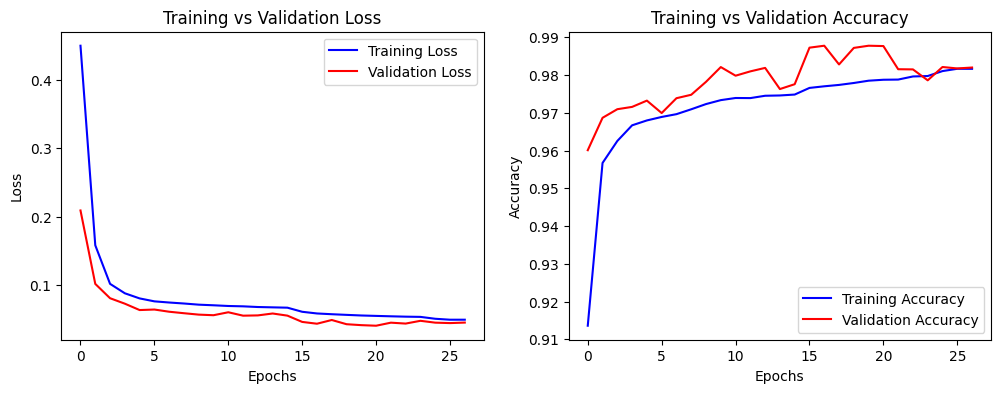

4548/4548 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


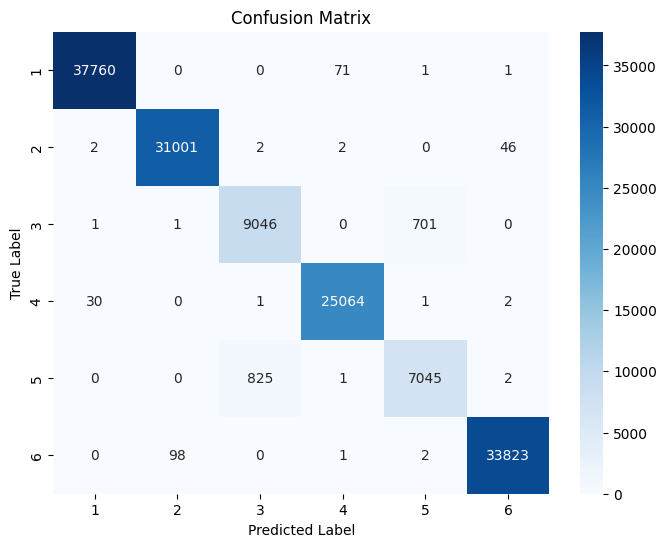


Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     37833
           2       1.00      1.00      1.00     31053
           3       0.92      0.93      0.92      9749
           4       1.00      1.00      1.00     25098
           5       0.91      0.89      0.90      7873
           6       1.00      1.00      1.00     33924

    accuracy                           0.99    145530
   macro avg       0.97      0.97      0.97    145530
weighted avg       0.99      0.99      0.99    145530



In [ ]:
# Add Gaussian noise to training data for better generalization
noise_factor = 0.005  # Slightly reduced noise
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)

# Define Optimized Neural Network Model
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),  # Increased dropout

    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
optimizer = Adam(learning_rate=0.0003)  # Slightly reduced learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks: Early Stopping & Learning Rate Reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)

# Train the model
history = model.fit(X_train_noisy, y_train, epochs=50, batch_size=256, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot Training & Validation Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Predict probabilities
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in label_encoder.classes_]))

In [ ]:
# Load cleaned test dataset
cleaned_test = pd.read_csv('cleaned_test.csv')

# Ensure 'outlet_city' is a string type
if 'outlet_city' in cleaned_test.columns:
    cleaned_test['outlet_city'] = cleaned_test['outlet_city'].astype(str)  # Convert to string if needed

# Apply the same encoding as in training
if 'outlet_city' in df.columns:  # Ensure training data had 'outlet_city'
    outlet_city_encoder = LabelEncoder()
    outlet_city_encoder.fit(df['outlet_city'])  # Fit on training data

    # Create a mapping dictionary from training cities
    outlet_city_mapping = dict(zip(outlet_city_encoder.classes_, outlet_city_encoder.transform(outlet_city_encoder.classes_)))

    # Encode outlet_city safely: Map known cities, assign -1 to unknowns
    cleaned_test['outlet_city'] = cleaned_test['outlet_city'].map(outlet_city_mapping).fillna(-1).astype(int)

# Select the same features used in training
X_cleaned_test = cleaned_test[['luxury_sales', 'fresh_sales', 'dry_sales', 'outlet_city']]

# Standardize using the same scaler
X_cleaned_test_scaled = scaler.transform(X_cleaned_test)

# Predict cluster categories
cleaned_test_predictions = model.predict(X_cleaned_test_scaled)
cleaned_test['Predicted_Cluster_Category'] = label_encoder.inverse_transform(np.argmax(cleaned_test_predictions, axis=1))

# Save predictions
cleaned_test.to_csv('cleaned_test_predictions.csv', index=False)

print("Predictions saved successfully!")


1274/1274 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Predictions saved successfully!
